In [1]:
!pip install transformers diffusers accelerate -U
!pip install parediffusers==0.2.0

In [13]:
import torch
from PIL import Image
from torchvision.transforms import ToPILImage
from transformers import CLIPTokenizer, CLIPTextModel
from parediffusers.scheduler import PareDDIMScheduler
from parediffusers.unet import PareUNet2DConditionModel
from diffusers import AutoencoderKL

class PareDiffusionPipeline:
	def __init__(self, tokenizer, text_encoder, scheduler, unet, vae, device=torch.device("cuda"), dtype=torch.float16):
		"""
		Initialize the diffusion pipeline components.
		"""
		self.tokenizer = tokenizer
		self.text_encoder = text_encoder.to(device=device, dtype=dtype)
		self.scheduler = scheduler
		self.unet = unet.to(device=device, dtype=dtype)
		self.vae = vae.to(device=device, dtype=dtype)
		self.device = device
		self.dtype = dtype

	@classmethod
	def from_pretrained(cls, model_name, device=torch.device("cuda"), dtype=torch.float16):
		"""
		Load all necessary components from the pretrained model.

		Args:
			model_name (str): The name of the pretrained model.
			device (torch.device, optional): The device to use for the pipeline. Defaults to torch.device("cuda").
			dtype (torch.dtype, optional): The dtype to use for the pipeline. Defaults to torch.float16.
		
		Returns:
			PareDiffusionPipeline: The initialized pipeline.
		"""
		tokenizer = CLIPTokenizer.from_pretrained(model_name, subfolder="tokenizer")
		text_encoder = CLIPTextModel.from_pretrained(model_name, subfolder="text_encoder")
		scheduler = PareDDIMScheduler.from_config(model_name, subfolder="scheduler")
		unet = PareUNet2DConditionModel.from_pretrained(model_name, subfolder="unet")
		vae = AutoencoderKL.from_pretrained(model_name, subfolder="vae")
		return cls(tokenizer, text_encoder, scheduler, unet, vae, device, dtype)

	def encode_prompt(self, prompt: str):
		"""
		Encode the text prompt into embeddings using the text encoder.
		"""
		prompt_embeds = self.get_embes(prompt, self.tokenizer.model_max_length)
		negative_prompt_embeds = self.get_embes([''], prompt_embeds.shape[1])
		prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])
		return prompt_embeds

	def get_embes(self, prompt, max_length):
		"""
		Encode the text prompt into embeddings using the text encoder.
		"""
		text_inputs = self.tokenizer(prompt, padding="max_length", max_length=max_length, truncation=True, return_tensors="pt")
		text_input_ids = text_inputs.input_ids.to(self.device)
		prompt_embeds = self.text_encoder(text_input_ids)[0].to(dtype=self.dtype, device=self.device)
		return prompt_embeds

	def get_latent(self, width: int, height: int):
		"""
		Generate a random initial latent tensor to start the diffusion process.
		"""
		return torch.randn((4, width // 8, height // 8)).to(
			device=self.device, dtype=self.dtype
		)

	def retrieve_timesteps(self, num_inference_steps=None):
		"""
		Retrieve the timesteps for the diffusion process from the scheduler.
		"""
		self.scheduler.set_timesteps(num_inference_steps, device=self.device)
		timesteps = self.scheduler.timesteps
		return timesteps, num_inference_steps

	@torch.no_grad()
	def denoise(self, latents, prompt_embeds, num_inference_steps=50, guidance_scale=7.5):
		"""
		Iteratively denoise the latent space using the diffusion model to produce an image.
		"""
		timesteps, num_inference_steps = self.retrieve_timesteps(num_inference_steps)
	
		for t in timesteps:
			latent_model_input = torch.cat([latents] * 2)
			
			# Predict the noise residual for the current timestep
			noise_residual = self.unet(latent_model_input, t, encoder_hidden_states=prompt_embeds)
			uncond_residual, text_cond_residual = noise_residual.chunk(2)
			guided_noise_residual = uncond_residual + guidance_scale * (text_cond_residual - uncond_residual)

			# Update latents by reversing the diffusion process for the current timestep
			latents = self.scheduler.step(guided_noise_residual, t, latents)[0]

		return latents
	
	def denormalize(self, image):
		"""
		Denormalize the image tensor to the range [0, 255].
		"""
		return (image / 2 + 0.5).clamp(0, 1)

	def tensor_to_image(self, tensor):
		"""
		Convert a tensor to a PIL Image.
		"""
		return ToPILImage()(tensor.detach().cpu())

	@torch.no_grad()
	def vae_decode(self, latents):
		"""
		Decode the latent tensors using the VAE to produce an image.
		"""
		image = self.vae.decode(latents / self.vae.config.scaling_factor)[0]
		image = self.denormalize(image)
		image = self.tensor_to_image(image)
		return image

	def __call__(self, prompt: str, height: int = 512, width: int = 512, num_inference_steps: int = 50, guidance_scale: int = 7.5):
		"""
		Generate an image from a text prompt using the entire pipeline.

		Args:
			prompt (str): The text prompt to generate an image from.
			height (int, optional): The height of the generated image. Defaults to 512.
			width (int, optional): The width of the generated image. Defaults to 512.
			num_inference_steps (int, optional): The number of diffusion steps to perform. Defaults to 50.
			guidance_scale (int, optional): The scale of the guidance. Defaults to 7.5.
		
		Returns:
			PIL.Image: The generated image.
		"""
		prompt_embeds = self.encode_prompt(prompt)
		latents = self.get_latent(width, height).unsqueeze(dim=0)
		latents = self.denoise(latents, prompt_embeds, num_inference_steps, guidance_scale)
		image = self.vae_decode(latents)
		return image


In [14]:
import torch
#from parediffusers import PareDiffusionPipeline

device = torch.device("cuda")
dtype = torch.float16
model_name = "stabilityai/stable-diffusion-2"
width = 512
height = 512
num_inference_steps = 50
prompt = "painting depicting the sea, sunrise, ship, artstation, 4k, concept art"


pipe = PareDiffusionPipeline.from_pretrained(model_name)

# Part 1: Write PareAutoencoderKL

In [2]:
DEFAULT_VAE_CONFIG = {
	"in_channels": 3,
	"out_channels": 3,
	"down_block_types": ["DownEncoderBlock2D", "DownEncoderBlock2D", "DownEncoderBlock2D", "DownEncoderBlock2D"],
	"up_block_types": ["UpDecoderBlock2D", "UpDecoderBlock2D", "UpDecoderBlock2D", "UpDecoderBlock2D"],
	"block_out_channels": [128, 256, 512, 512],
	"layers_per_block": 2,
	"act_fn": "silu",
	"latent_channels": 4,
	"norm_num_groups": 32,
	"sample_size": 768,
	"scaling_factor": 0.18215,
	"force_upcast": True,
	"_use_default_values": ["scaling_factor", "force_upcast"],
	"_class_name": "AutoencoderKL",
	"_diffusers_version": "0.8.0",
	"_name_or_path": "stabilityai/stable-diffusion-2",	
}


class DotDict(dict):
	"""dot.notation access to dictionary attributes"""
	__getattr__ = dict.get
	__setattr__ = dict.__setitem__
	__delattr__ = dict.__delitem__

In [180]:
from typing import Optional, Tuple, List
import json
import torch
import torch.nn as nn
from huggingface_hub import hf_hub_download

from diffusers.models.autoencoders.vae import Decoder, DiagonalGaussianDistribution, Encoder

class PareAutoencoderKL(nn.Module):
	def __init__(self, **kwargs):
		super().__init__()
		self.config = DotDict(DEFAULT_VAE_CONFIG)
		self.config.update(kwargs)

		# pass init params to Encoder
		self.encoder = Encoder(
			in_channels=self.config.in_channels,
			out_channels=self.config.latent_channels,
			down_block_types=self.config.down_block_types,
			block_out_channels=self.config.block_out_channels,
			layers_per_block=self.config.layers_per_block,
		)

		# pass init params to Decoder
		self.decoder = Decoder(
			in_channels=self.config.latent_channels,
			out_channels=self.config.out_channels,
			up_block_types=self.config.up_block_types,
			block_out_channels=self.config.block_out_channels,
			layers_per_block=self.config.layers_per_block,
		)

		self.quant_conv = nn.Conv2d(2 * self.config.latent_channels, 2 * self.config.latent_channels, 1)
		self.post_quant_conv = nn.Conv2d(self.config.latent_channels, self.config.latent_channels, 1)

		self.use_slicing = False
		self.use_tiling = False

		# only relevant if vae tiling is enabled
		self.tile_sample_min_size = self.config.sample_size
		sample_size = (
			self.config.sample_size[0]
			if isinstance(self.config.sample_size, (list, tuple))
			else self.config.sample_size
		)
		self.tile_latent_min_size = int(sample_size / (2 ** (len(self.config.block_out_channels) - 1)))
		self.tile_overlap_factor = 0.25

	@classmethod
	def _get_config(cls, model_name: str, filename: str = "config.json", subfolder: str = "unet") -> dict:
		config_file = hf_hub_download(
			model_name,
			filename=filename,
			subfolder=subfolder,
		)
		with open(config_file, "r", encoding="utf-8") as reader:
			text = reader.read()
		config = json.loads(text)
		return config

	@classmethod
	def _load_state_dict_into_model(cls, model: nn.Module, state_dict: dict) -> List[str]:
		state_dict = state_dict.copy()
		error_msgs = []

		def load(module: torch.nn.Module, prefix: str = ""):
			args = (state_dict, prefix, {}, True, [], [], error_msgs)
			module._load_from_state_dict(*args)
			for name, child in module._modules.items():
				if child is not None:
					load(child, prefix + name + ".")
		
		load(model)
		return model
	
	@classmethod
	def from_pretrained(cls, model_name: str, **kwargs) -> nn.Module:
		subfolder = kwargs.pop("subfolder", "vae")
		config_filename = kwargs.pop("config_filename", "config.json")
		model_filename = kwargs.pop("model_filename", "diffusion_pytorch_model.fp16.bin")
		
		config = cls._get_config(model_name, filename=config_filename, subfolder=subfolder)
		model_file = hf_hub_download(
			model_name,
			filename=model_filename,
			subfolder=subfolder,
		)
		state_dict = torch.load(model_file, map_location="cpu")
		
		model = PareAutoencoderKL(**config)
		model = cls._load_state_dict_into_model(model, state_dict)
		model.eval()
		return model

	def encode(self, x: torch.FloatTensor):
		h = self.encoder(x)
		moments = self.quant_conv(h)
		posterior = DiagonalGaussianDistribution(moments)
		return posterior

	def _decode(self, z: torch.FloatTensor) -> torch.FloatTensor:
		z = self.post_quant_conv(z)
		dec = self.decoder(z)
		return dec

	def decode(self, z: torch.FloatTensor) -> torch.FloatTensor:
		decoded = self._decode(z)
		return decoded

	def forward(
		self,
		sample: torch.FloatTensor,
	) -> torch.FloatTensor:
		x = sample
		posterior = self.encode(x).latent_dist
		z = posterior.mode()
		dec = self.decode(z).sample
		return dec

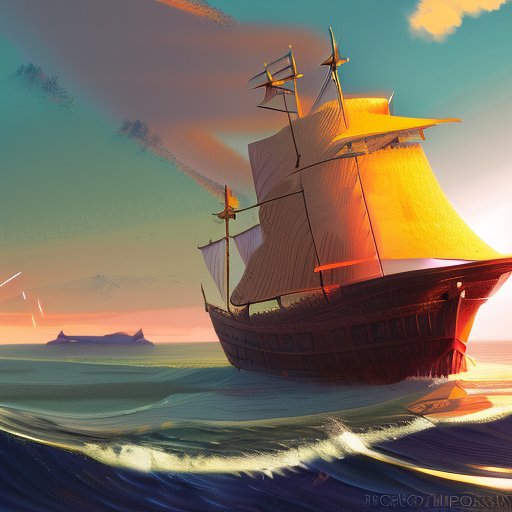

In [181]:
pare_vae = PareAutoencoderKL.from_pretrained("stabilityai/stable-diffusion-2", subfolder="vae").to(
	device=device,
	dtype=dtype
)

pipe.vae = pare_vae

image = pipe(prompt)
image.show()

# Part 2: Write PareEncoder and PareDecoder

In [3]:
import torch
from torch import nn
from typing import Optional
from parediffusers.utils import get_activation


class PareResnetBlock2D(nn.Module):
	def __init__(
		self,
		in_channels: int,
		out_channels: Optional[int] = None,
		temb_channels: int = 512,
		eps: float = 1e-6,
		groups: int = 32,
		groups_out: Optional[int] = None,
		dropout: float = 0.0,
		non_linearity: str = "swish",
		output_scale_factor: float = 1.0,
	):
		super().__init__()
		self.in_channels = in_channels
		out_channels = in_channels if out_channels is None else out_channels
		self.out_channels = out_channels
		self.output_scale_factor = output_scale_factor

		linear_cls = nn.Linear
		conv_cls = nn.Conv2d

		if groups_out is None:
			groups_out = groups

		self.norm1 = torch.nn.GroupNorm(num_groups=groups, num_channels=in_channels, eps=eps, affine=True)

		self.conv1 = conv_cls(in_channels, out_channels, kernel_size=3, stride=1, padding=1)

		if temb_channels is not None:
			self.time_emb_proj = linear_cls(temb_channels, out_channels)
		else:
			self.time_emb_proj = None

		self.norm2 = torch.nn.GroupNorm(num_groups=groups_out, num_channels=out_channels, eps=eps, affine=True)

		self.dropout = torch.nn.Dropout(dropout)
		self.conv2 = conv_cls(out_channels, out_channels, kernel_size=3, stride=1, padding=1)

		self.nonlinearity = get_activation(non_linearity)

		self.upsample = self.downsample = None
		self.use_in_shortcut = self.in_channels != out_channels

		self.conv_shortcut = None
		if self.use_in_shortcut:
			self.conv_shortcut = conv_cls(
				in_channels,
				out_channels,
				kernel_size=1,
				stride=1,
				padding=0,
				bias=True,
			)

	def forward(
		self,
		input_tensor: torch.FloatTensor,
		temb: torch.FloatTensor,
	) -> torch.FloatTensor:
		hidden_states = input_tensor

		hidden_states = self.norm1(hidden_states)
		hidden_states = self.nonlinearity(hidden_states)

		if self.upsample is not None:
			if hidden_states.shape[0] >= 64:
				input_tensor = input_tensor.contiguous()
				hidden_states = hidden_states.contiguous()
			input_tensor = (
				self.upsample(input_tensor)
			)
			hidden_states = (
				self.upsample(hidden_states)
			)
		elif self.downsample is not None:
			input_tensor = (
				self.downsample(input_tensor)
			)
			hidden_states = (
				self.downsample(hidden_states)
			)

		hidden_states = self.conv1(hidden_states)

		if self.time_emb_proj is not None:
			temb = self.nonlinearity(temb)
			temb = (
				self.time_emb_proj(temb)[:, :, None, None]
			)

		if temb is not None:
			hidden_states = hidden_states + temb
		hidden_states = self.norm2(hidden_states)

		hidden_states = self.nonlinearity(hidden_states)

		hidden_states = self.dropout(hidden_states)
		hidden_states = self.conv2(hidden_states)

		if self.conv_shortcut is not None:
			input_tensor = (
				self.conv_shortcut(input_tensor)
			)

		output_tensor = (input_tensor + hidden_states) / self.output_scale_factor

		return output_tensor

In [4]:
#from diffusers.models.resnet import ResnetBlock2D
#from parediffusers.models.resnet import PareResnetBlock2D
from parediffusers.models.attension import PareAttention

class PareUNetMidBlock2D(nn.Module):
	def __init__(
		self,
		in_channels: int,
		temb_channels: int,
		dropout: float = 0.0,
		num_layers: int = 1,
		resnet_eps: float = 1e-6,
		resnet_time_scale_shift: str = "default",  # default, spatial
		resnet_act_fn: str = "swish",
		resnet_groups: int = 32,
		attn_groups: Optional[int] = None,
		add_attention: bool = True,
		attention_head_dim: int = 1,
		output_scale_factor: float = 1.0,
	):
		super().__init__()
		resnet_groups = resnet_groups if resnet_groups is not None else min(in_channels // 4, 32)
		self.add_attention = add_attention

		if attn_groups is None:
			attn_groups = resnet_groups if resnet_time_scale_shift == "default" else None

		resnets = [
			PareResnetBlock2D(
				in_channels=in_channels,
				out_channels=in_channels,
				temb_channels=temb_channels,
				eps=resnet_eps,
				groups=resnet_groups,
				dropout=dropout,
				non_linearity=resnet_act_fn,
				output_scale_factor=output_scale_factor,
			)
		]
		attentions = []

		if attention_head_dim is None:
			attention_head_dim = in_channels

		for _ in range(num_layers):
			if self.add_attention:
				attentions.append(
					PareAttention(
						in_channels,
						heads=in_channels // attention_head_dim,
						dim_head=attention_head_dim,
						rescale_output_factor=output_scale_factor,
						eps=resnet_eps,
						norm_num_groups=attn_groups,
						spatial_norm_dim=temb_channels if resnet_time_scale_shift == "spatial" else None,
						residual_connection=True,
						bias=True,
						upcast_softmax=True,
						_from_deprecated_attn_block=True,
					)
				)
			else:
				attentions.append(None)

			resnets.append(
				PareResnetBlock2D(
					in_channels=in_channels,
					out_channels=in_channels,
					temb_channels=temb_channels,
					eps=resnet_eps,
					groups=resnet_groups,
					dropout=dropout,
					non_linearity=resnet_act_fn,
					output_scale_factor=output_scale_factor,
				)
			)

		self.attentions = nn.ModuleList(attentions)
		self.resnets = nn.ModuleList(resnets)

	def forward(self, hidden_states: torch.FloatTensor, temb: Optional[torch.FloatTensor] = None) -> torch.FloatTensor:
		hidden_states = self.resnets[0](hidden_states, temb)
		for attn, resnet in zip(self.attentions, self.resnets[1:]):
			if attn is not None:
				hidden_states = attn(hidden_states, temb=temb)
			hidden_states = resnet(hidden_states, temb)

		return hidden_states

In [5]:
from parediffusers.models.unet_2d_blocks import PareUpsample2D

class PareUpDecoderBlock2D(nn.Module):
	def __init__(
		self,
		in_channels: int,
		out_channels: int,
		resolution_idx: Optional[int] = None,
		dropout: float = 0.0,
		num_layers: int = 1,
		resnet_eps: float = 1e-6,
		resnet_time_scale_shift: str = "default",  # default, spatial
		resnet_act_fn: str = "swish",
		resnet_groups: int = 32,
		resnet_pre_norm: bool = True,
		output_scale_factor: float = 1.0,
		add_upsample: bool = True,
		temb_channels: Optional[int] = None,
	):
		super().__init__()
		resnets = []

		for i in range(num_layers):
			input_channels = in_channels if i == 0 else out_channels

			resnets.append(
				PareResnetBlock2D(
					in_channels=input_channels,
					out_channels=out_channels,
					temb_channels=temb_channels,
					eps=resnet_eps,
					groups=resnet_groups,
					dropout=dropout,
					non_linearity=resnet_act_fn,
					output_scale_factor=output_scale_factor,
				)
			)

		self.resnets = nn.ModuleList(resnets)

		if add_upsample:
			self.upsamplers = nn.ModuleList([PareUpsample2D(out_channels, use_conv=True, out_channels=out_channels)])
		else:
			self.upsamplers = None

		self.resolution_idx = resolution_idx

	def forward(
		self, hidden_states: torch.FloatTensor, temb: Optional[torch.FloatTensor] = None
	) -> torch.FloatTensor:
		for resnet in self.resnets:
			hidden_states = resnet(hidden_states, temb=temb)

		if self.upsamplers is not None:
			for upsampler in self.upsamplers:
				hidden_states = upsampler(hidden_states)

		return hidden_states

In [6]:

def pare_get_up_block(
	up_block_type: str,
	num_layers: int,
	in_channels: int,
	out_channels: int,
	prev_output_channel: int,
	temb_channels: int,
	add_upsample: bool,
	resnet_eps: float,
	resnet_act_fn: str,
	resolution_idx: Optional[int] = None,
	transformer_layers_per_block: int = 1,
	num_attention_heads: Optional[int] = None,
	resnet_groups: Optional[int] = None,
	cross_attention_dim: Optional[int] = None,
	dual_cross_attention: bool = False,
	use_linear_projection: bool = False,
	only_cross_attention: bool = False,
	attention_head_dim: Optional[int] = None,
	upcast_attention: bool = False,
	dropout: float = 0.0,
) -> nn.Module:
	if attention_head_dim is None:
		attention_head_dim = num_attention_heads
	up_block_type = up_block_type[7:] if up_block_type.startswith("UNetRes") else up_block_type
	if up_block_type == "UpBlock2D":
		return PareUpBlock2D(
			num_layers=num_layers,
			in_channels=in_channels,
			out_channels=out_channels,
			prev_output_channel=prev_output_channel,
			temb_channels=temb_channels,
			resolution_idx=resolution_idx,
			dropout=dropout,
			add_upsample=add_upsample,
			resnet_eps=resnet_eps,
			resnet_act_fn=resnet_act_fn,
			resnet_groups=resnet_groups,
		)
	elif up_block_type == "CrossAttnUpBlock2D":
		if cross_attention_dim is None:
			raise ValueError("cross_attention_dim must be specified for CrossAttnUpBlock2D")
		return PareCrossAttnUpBlock2D(
			num_layers=num_layers,
			transformer_layers_per_block=transformer_layers_per_block,
			in_channels=in_channels,
			out_channels=out_channels,
			prev_output_channel=prev_output_channel,
			temb_channels=temb_channels,
			resolution_idx=resolution_idx,
			dropout=dropout,
			add_upsample=add_upsample,
			resnet_groups=resnet_groups,
			cross_attention_dim=cross_attention_dim,
			num_attention_heads=num_attention_heads,
			dual_cross_attention=dual_cross_attention,
			use_linear_projection=use_linear_projection,
			only_cross_attention=only_cross_attention,
			upcast_attention=upcast_attention,
		)
	
	elif up_block_type == "UpDecoderBlock2D":
		return PareUpDecoderBlock2D(
			num_layers=num_layers,
			in_channels=in_channels,
			out_channels=out_channels,
			resolution_idx=resolution_idx,
			dropout=dropout,
			add_upsample=add_upsample,
			resnet_eps=resnet_eps,
			resnet_act_fn=resnet_act_fn,
			resnet_groups=resnet_groups,
			temb_channels=temb_channels,
		)


In [10]:
import numpy as np
import torch
import torch.nn as nn
from typing import Optional, Tuple
from parediffusers.models.unet_2d_get_blocks import pare_get_down_block
#from parediffusers.models.unet_2d_get_blocks import pare_get_up_block, pare_get_down_block

class PareEncoder(nn.Module):
	def __init__(
		self,
		in_channels: int = 3,
		out_channels: int = 3,
		down_block_types: Tuple[str, ...] = ("PareDownEncoderBlock2D",),
		block_out_channels: Tuple[int, ...] = (64,),
		layers_per_block: int = 2,
		norm_num_groups: int = 32,
		act_fn: str = "silu",
		double_z: bool = True,
		mid_block_add_attention=True,
	):
		super().__init__()
		self.layers_per_block = layers_per_block

		self.conv_in = nn.Conv2d(
			in_channels,
			block_out_channels[0],
			kernel_size=3,
			stride=1,
			padding=1,
		)

		self.mid_block = None
		self.down_blocks = nn.ModuleList([])

		# down
		output_channel = block_out_channels[0]
		for i, down_block_type in enumerate(down_block_types):
			input_channel = output_channel
			output_channel = block_out_channels[i]
			is_final_block = i == len(block_out_channels) - 1

			down_block = pare_get_down_block(
				down_block_type,
                num_layers=self.layers_per_block,
                in_channels=input_channel,
                out_channels=output_channel,
                add_downsample=not is_final_block,
                resnet_eps=1e-6,
                downsample_padding=0,
                resnet_act_fn=act_fn,
                resnet_groups=norm_num_groups,
                temb_channels=None,
			)
			self.down_blocks.append(down_block)

		# mid
		self.mid_block = PareUNetMidBlock2D(
			in_channels=block_out_channels[-1],
			resnet_eps=1e-6,
			resnet_act_fn=act_fn,
			output_scale_factor=1,
			attention_head_dim=block_out_channels[-1],
			resnet_groups=norm_num_groups,
			temb_channels=None,
			add_attention=mid_block_add_attention,
		)

		# out
		self.conv_norm_out = nn.GroupNorm(num_channels=block_out_channels[-1], num_groups=norm_num_groups, eps=1e-6)
		self.conv_act = nn.SiLU()

		conv_out_channels = 2 * out_channels if double_z else out_channels
		self.conv_out = nn.Conv2d(block_out_channels[-1], conv_out_channels, 3, padding=1)

		self.gradient_checkpointing = False

	def forward(self, sample: torch.FloatTensor) -> torch.FloatTensor:
		sample = self.conv_in(sample)
		
		# down
		for down_block in self.down_blocks:
			sample = down_block(sample)

		# middle
		sample = self.mid_block(sample)

		# post-process
		sample = self.conv_norm_out(sample)
		sample = self.conv_act(sample)
		sample = self.conv_out(sample)

		return sample


class PareDecoder(nn.Module):
	def __init__(
		self,
		in_channels: int = 3,
		out_channels: int = 3,
		up_block_types: Tuple[str, ...] = ("PareUpDecoderBlock2D",),
		block_out_channels: Tuple[int, ...] = (64,),
		layers_per_block: int = 2,
		norm_num_groups: int = 32,
		act_fn: str = "silu",
		norm_type: str = "group",  # group, spatial
		mid_block_add_attention=True,
	):
		super().__init__()
		self.layers_per_block = layers_per_block

		self.conv_in = nn.Conv2d(
			in_channels,
			block_out_channels[-1],
			kernel_size=3,
			stride=1,
			padding=1,
		)

		self.mid_block = None
		self.up_blocks = nn.ModuleList([])

		temb_channels = in_channels if norm_type == "spatial" else None

		# mid
		self.mid_block = PareUNetMidBlock2D(
			in_channels=block_out_channels[-1],
			resnet_eps=1e-6,
			resnet_act_fn=act_fn,
			output_scale_factor=1,
			attention_head_dim=block_out_channels[-1],
			resnet_groups=norm_num_groups,
			temb_channels=temb_channels,
			add_attention=mid_block_add_attention,
		)

		# up
		reversed_block_out_channels = list(reversed(block_out_channels))
		output_channel = reversed_block_out_channels[0]
		for i, up_block_type in enumerate(up_block_types):
			prev_output_channel = output_channel
			output_channel = reversed_block_out_channels[i]

			is_final_block = i == len(block_out_channels) - 1

			up_block = pare_get_up_block(
				up_block_type,
                num_layers=self.layers_per_block + 1,
                in_channels=prev_output_channel,
                out_channels=output_channel,
                prev_output_channel=None,
                add_upsample=not is_final_block,
                resnet_eps=1e-6,
                resnet_act_fn=act_fn,
                resnet_groups=norm_num_groups,
				attention_head_dim=output_channel,
                temb_channels=temb_channels,
			)
			self.up_blocks.append(up_block)
			prev_output_channel = output_channel

		# out
		self.conv_norm_out = nn.GroupNorm(num_channels=block_out_channels[0], num_groups=norm_num_groups, eps=1e-6)
		self.conv_act = nn.SiLU()
		self.conv_out = nn.Conv2d(block_out_channels[0], out_channels, 3, padding=1)

		self.gradient_checkpointing = False

	def forward(
		self,
		sample: torch.FloatTensor,
		latent_embeds: Optional[torch.FloatTensor] = None,
	) -> torch.FloatTensor:
		r"""The forward method of the `Decoder` class."""

		sample = self.conv_in(sample)

		# middle
		sample = self.mid_block(sample, latent_embeds)

		# up
		for up_block in self.up_blocks:
			sample = up_block(sample, latent_embeds)

		# post-process
		if latent_embeds is None:
			sample = self.conv_norm_out(sample)
		else:
			sample = self.conv_norm_out(sample, latent_embeds)
		sample = self.conv_act(sample)
		sample = self.conv_out(sample)

		return sample
	

class PareDiagonalGaussianDistribution(object):
    def __init__(self, parameters: torch.Tensor, deterministic: bool = False):
        self.parameters = parameters
        self.mean, self.logvar = torch.chunk(parameters, 2, dim=1)
        self.logvar = torch.clamp(self.logvar, -30.0, 20.0)
        self.deterministic = deterministic
        self.std = torch.exp(0.5 * self.logvar)
        self.var = torch.exp(self.logvar)
        if self.deterministic:
            self.var = self.std = torch.zeros_like(
                self.mean, device=self.parameters.device, dtype=self.parameters.dtype
            )

    def kl(self, other: "PareDiagonalGaussianDistribution" = None) -> torch.Tensor:
        if self.deterministic:
            return torch.Tensor([0.0])
        else:
            if other is None:
                return 0.5 * torch.sum(
                    torch.pow(self.mean, 2) + self.var - 1.0 - self.logvar,
                    dim=[1, 2, 3],
                )
            else:
                return 0.5 * torch.sum(
                    torch.pow(self.mean - other.mean, 2) / other.var
                    + self.var / other.var
                    - 1.0
                    - self.logvar
                    + other.logvar,
                    dim=[1, 2, 3],
                )

    def nll(self, sample: torch.Tensor, dims: Tuple[int, ...] = [1, 2, 3]) -> torch.Tensor:
        if self.deterministic:
            return torch.Tensor([0.0])
        logtwopi = np.log(2.0 * np.pi)
        return 0.5 * torch.sum(
            logtwopi + self.logvar + torch.pow(sample - self.mean, 2) / self.var,
            dim=dims,
        )

    def mode(self) -> torch.Tensor:
        return self.mean

In [11]:
from typing import Optional, Tuple, List
import json
import torch
import torch.nn as nn
from huggingface_hub import hf_hub_download

class PareAutoencoderKL(nn.Module):
	def __init__(self, **kwargs):
		super().__init__()
		self.config = DotDict(DEFAULT_VAE_CONFIG)
		self.config.update(kwargs)

		# pass init params to Encoder
		self.encoder = PareEncoder(
			in_channels=self.config.in_channels,
			out_channels=self.config.latent_channels,
			down_block_types=self.config.down_block_types,
			block_out_channels=self.config.block_out_channels,
			layers_per_block=self.config.layers_per_block,
		)

		# pass init params to Decoder
		self.decoder = PareDecoder(
			in_channels=self.config.latent_channels,
			out_channels=self.config.out_channels,
			up_block_types=self.config.up_block_types,
			block_out_channels=self.config.block_out_channels,
			layers_per_block=self.config.layers_per_block,
		)

		self.quant_conv = nn.Conv2d(2 * self.config.latent_channels, 2 * self.config.latent_channels, 1)
		self.post_quant_conv = nn.Conv2d(self.config.latent_channels, self.config.latent_channels, 1)

		self.use_slicing = False
		self.use_tiling = False

		# only relevant if vae tiling is enabled
		self.tile_sample_min_size = self.config.sample_size
		sample_size = (
			self.config.sample_size[0]
			if isinstance(self.config.sample_size, (list, tuple))
			else self.config.sample_size
		)
		self.tile_latent_min_size = int(sample_size / (2 ** (len(self.config.block_out_channels) - 1)))
		self.tile_overlap_factor = 0.25

	@classmethod
	def _get_config(cls, model_name: str, filename: str = "config.json", subfolder: str = "unet") -> dict:
		config_file = hf_hub_download(
			model_name,
			filename=filename,
			subfolder=subfolder,
		)
		with open(config_file, "r", encoding="utf-8") as reader:
			text = reader.read()
		config = json.loads(text)
		return config

	@classmethod
	def _load_state_dict_into_model(cls, model: nn.Module, state_dict: dict) -> List[str]:
		state_dict = state_dict.copy()
		error_msgs = []

		def load(module: torch.nn.Module, prefix: str = ""):
			args = (state_dict, prefix, {}, True, [], [], error_msgs)
			module._load_from_state_dict(*args)
			for name, child in module._modules.items():
				if child is not None:
					load(child, prefix + name + ".")
		
		load(model)
		return model
	
	@classmethod
	def from_pretrained(cls, model_name: str, **kwargs) -> nn.Module:
		subfolder = kwargs.pop("subfolder", "vae")
		config_filename = kwargs.pop("config_filename", "config.json")
		model_filename = kwargs.pop("model_filename", "diffusion_pytorch_model.fp16.bin")
		
		config = cls._get_config(model_name, filename=config_filename, subfolder=subfolder)
		model_file = hf_hub_download(
			model_name,
			filename=model_filename,
			subfolder=subfolder,
		)
		state_dict = torch.load(model_file, map_location="cpu")
		
		model = PareAutoencoderKL(**config)
		model = cls._load_state_dict_into_model(model, state_dict)
		model.eval()
		return model

	def encode(self, x: torch.FloatTensor):
		h = self.encoder(x)
		moments = self.quant_conv(h)
		posterior = PareDiagonalGaussianDistribution(moments)
		return posterior

	def _decode(self, z: torch.FloatTensor) -> torch.FloatTensor:
		z = self.post_quant_conv(z)
		dec = self.decoder(z)
		return dec

	def decode(self, z: torch.FloatTensor) -> torch.FloatTensor:
		decoded = self._decode(z)
		return decoded

	def forward(
		self,
		sample: torch.FloatTensor,
	) -> torch.FloatTensor:
		x = sample
		posterior = self.encode(x).latent_dist
		z = posterior.mode()
		dec = self.decode(z).sample
		return dec

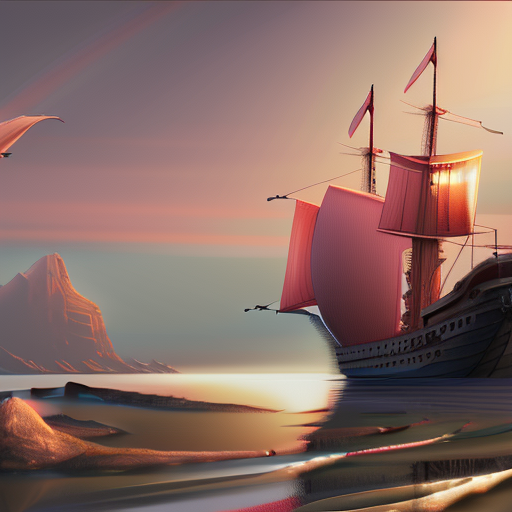

In [15]:
pare_vae = PareAutoencoderKL.from_pretrained("stabilityai/stable-diffusion-2", subfolder="vae").to(
	device=device,
	dtype=dtype
)

pipe.vae = pare_vae

image = pipe(prompt)
image.show()